# Perform standard imports

In [1]:
import torch
from torch import nn, optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load the dataset

In [2]:
#data = pd.read_csv("Sales_Transactions_Dataset_Weekly.csv", skiprows=1, header=None)
data = pd.read_csv("Sales_Transactions_Dataset_Weekly.csv")
data = data.iloc[:,1:53]
data.head()

,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,11,12,10,8,13,12,14,21,6,14,...,4,7,8,10,12,3,7,6,5,10
1,7,6,3,2,7,1,6,3,3,3,...,2,4,5,1,1,4,5,1,6,0
2,7,11,8,9,10,8,7,13,12,6,...,6,14,5,5,7,8,14,8,8,7
3,12,8,13,5,9,6,9,13,13,11,...,9,10,3,4,6,8,14,8,7,8
4,8,5,13,11,6,7,9,14,9,9,...,7,11,7,12,6,6,5,11,8,9


# Plotting sales transaction of 5 random products

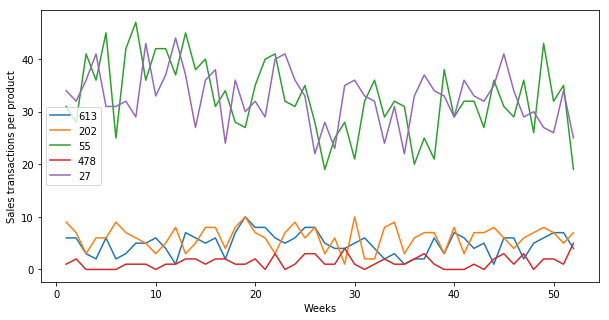

In [3]:
plot_data = data.sample(5, random_state=0)
x = range(1,53)

plt.figure(figsize=(10,5))

for i,row in plot_data.iterrows():
    plt.plot(x,row)

plt.legend(plot_data.index)
plt.xlabel("Weeks")
plt.ylabel("Sales transactions per product")
plt.show()

In [4]:
# selecting the training data. Use 51 weeks and leave 1 week out.

data_train = data.iloc[:,:-1]
inputs = torch.Tensor(data_train.values).unsqueeze(1)

# shift index axis by a given period in positive/negative direction
# axis = 0 is set by default
# in our case here, we move everything to the left and the right most
# column adds nan. you can play with the negative -1 value and print targets
# to see the effect

targets = data_train.shift(-1, axis="columns").astype(dtype = "float32")
#print(data)
#print(targets)
targets['W50'] = data['W51']
targets = torch.Tensor(targets.values)
#print(targets)

# Defining our model
During training we pass three tensors through the LSTM layer - the sequence, the hidden state  ℎ0  and the cell state  𝑐0 .

This means we need to initialize  ℎ0  and  𝑐0 . This can be done with random values, but we'll use zeros instead.

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super(RNN, self).__init__()
        
        # hidden dimension size
        self.hidden_size = hidden_size
        
        # Add an LSTM/GRU layer:
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        
        # Add a fully-connected layer:
        self.output = nn.Linear(hidden_size, output_size)
        
    
    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = out.view(-1, self.hidden_size)
        out = self.output(out)
        
        return out, hidden

# Instantiate the model, define loss and optimization functions

In [6]:

model = RNN(data_train.shape[1], 10, 1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10000

model

RNN(
  (rnn): GRU(51, 10, batch_first=True)
  (output): Linear(in_features=10, out_features=1, bias=True)
)

In [7]:
import time

start_time = time.time()
losses = []

for i in range(1, epochs+1):
    
    hidden = None
    pred, hidden = model(inputs, hidden)
    
    loss = criterion(pred, targets)
    # reset the parameters and hidden states
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

    if i%1000 == 0:
        # print training result
        print(f'Epoch: {i} Loss: {loss.item():10.8f}')
        

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

/Users/saidulislam/anaconda3/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([811, 51])) that is different to the input size (torch.Size([811, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1000 Loss: 98.80258942
Epoch: 2000 Loss: 54.15067291
Epoch: 3000 Loss: 29.95164680
Epoch: 4000 Loss: 18.56268883
Epoch: 5000 Loss: 14.96900749
Epoch: 6000 Loss: 14.29080296
Epoch: 7000 Loss: 14.10709953
Epoch: 8000 Loss: 13.97752857
Epoch: 9000 Loss: 13.95545769
Epoch: 10000 Loss: 13.95960331
Epoch: 11000 Loss: 13.92994690
Epoch: 12000 Loss: 13.89620590
Epoch: 13000 Loss: 13.88830376
Epoch: 14000 Loss: 13.86467552
Epoch: 15000 Loss: 13.85581493
Epoch: 16000 Loss: 13.85323906
Epoch: 17000 Loss: 13.85260582
Epoch: 18000 Loss: 13.85136700
Epoch: 19000 Loss: 13.84997272
Epoch: 20000 Loss: 13.84412384

Duration: 55 seconds


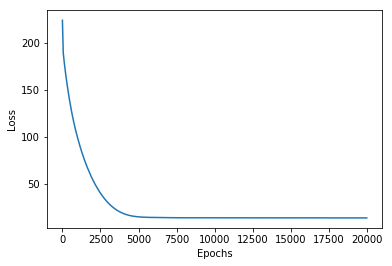

In [8]:
x_range = range(len(losses))
plt.plot(x_range, losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

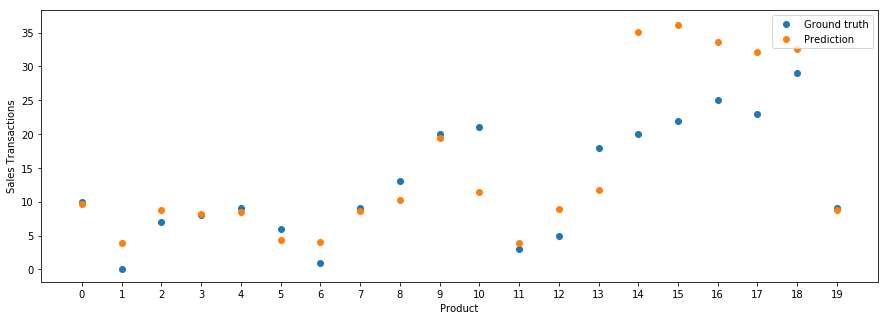

In [9]:
x_range = range(len(data))
target = data.iloc[:,-1].values.reshape(len(data),1)
plt.figure(figsize=(15,5))
plt.scatter(x_range[:20], target[:20])
plt.scatter(x_range[:20], pred.detach().numpy()[:20])
plt.legend(["Ground truth", "Prediction"])
plt.xlabel("Product")
plt.ylabel("Sales Transactions")
plt.xticks(range(0, 20))
plt.show()

# 52 weeks sales of item 1 or the first row

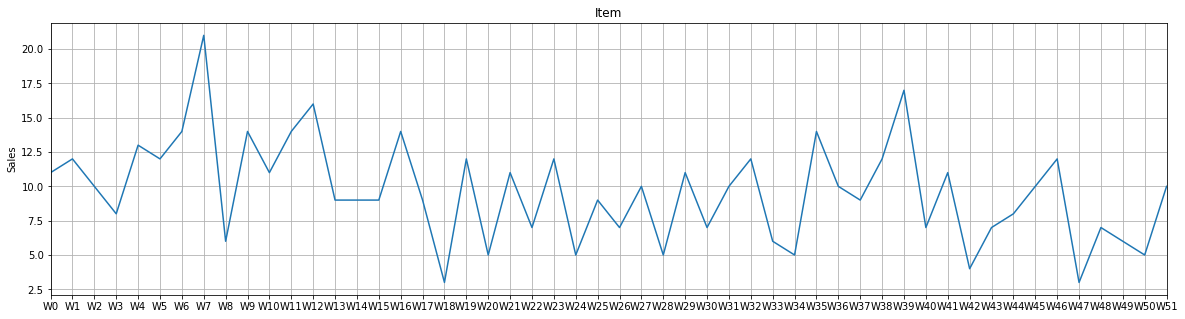

In [10]:
plt.figure(figsize=(20,5))
plt.title('Item')
plt.ylabel('Sales')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(data.iloc[0])
plt.plot(x_range[:0],pred.detach().numpy()[:0])
plt.show()

# Predicted values of the last column

In [11]:
predicted_values = pred.detach().numpy().squeeze().tolist()
predicted_values = [int(i) for i in predicted_values]
predicted_values

[9,
 3,
 8,
 8,
 8,
 4,
 4,
 8,
 10,
 19,
 11,
 3,
 8,
 11,
 35,
 36,
 33,
 32,
 32,
 8,
 8,
 9,
 4,
 36,
 30,
 10,
 34,
 32,
 12,
 32,
 8,
 8,
 11,
 36,
 34,
 35,
 35,
 36,
 33,
 35,
 34,
 31,
 37,
 32,
 31,
 33,
 33,
 34,
 34,
 8,
 17,
 32,
 4,
 35,
 31,
 32,
 33,
 33,
 9,
 32,
 32,
 16,
 35,
 31,
 9,
 35,
 32,
 8,
 33,
 32,
 9,
 35,
 32,
 9,
 35,
 32,
 4,
 31,
 33,
 30,
 8,
 8,
 34,
 33,
 31,
 32,
 31,
 31,
 32,
 32,
 8,
 37,
 8,
 8,
 12,
 34,
 31,
 4,
 9,
 11,
 35,
 31,
 8,
 3,
 3,
 10,
 17,
 2,
 9,
 8,
 4,
 34,
 31,
 9,
 10,
 9,
 4,
 9,
 33,
 33,
 8,
 8,
 3,
 4,
 8,
 4,
 2,
 35,
 35,
 34,
 33,
 34,
 34,
 35,
 37,
 35,
 36,
 31,
 32,
 33,
 32,
 32,
 32,
 9,
 8,
 8,
 9,
 3,
 9,
 3,
 4,
 9,
 9,
 8,
 3,
 3,
 8,
 3,
 4,
 9,
 4,
 8,
 3,
 8,
 9,
 9,
 33,
 34,
 30,
 32,
 8,
 34,
 36,
 36,
 35,
 32,
 33,
 37,
 36,
 35,
 32,
 31,
 32,
 34,
 34,
 34,
 30,
 32,
 32,
 36,
 35,
 32,
 35,
 30,
 4,
 32,
 9,
 10,
 3,
 17,
 3,
 15,
 6,
 2,
 12,
 2,
 5,
 31,
 9,
 12,
 11,
 0,
 0,
 0,
 0,
 0,
 0,
 0,